<a href="https://colab.research.google.com/github/Murari2124/Crack-detection-using-Convolution-Neural-Network/blob/main/Copy_of_crack_detection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from PIL import Image
import PIL.ImageOps
import numpy as np
from skimage.io import imsave
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [19]:
!pip install patool


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.2 MB/s eta 0:00:00


In [20]:
import patoolib

In [21]:

# Extract the file
patoolib.extract_archive('/content/drive/MyDrive/dataset.zip')

patool: Extracting /content/drive/MyDrive/dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_zdzafbfz -- /content/drive/MyDrive/dataset.zip
patool: ... /content/drive/MyDrive/dataset.zip extracted to `dataset'.


'dataset'

In [23]:
positive_dir = Path('/content/dataset/Positive')
negative_dir = Path('/content/dataset/Negative')

In [13]:
def creat_dataframe(pic_dir, label):
    filepaths = pd.Series(list(pic_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [24]:
positive_df = creat_dataframe(positive_dir, label="POSITIVE")
negative_df = creat_dataframe(negative_dir, label="NEGATIVE")
print(positive_df)
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df


                                    Filepath     Label
0      /content/dataset/Positive/12187_1.jpg  POSITIVE
1      /content/dataset/Positive/16459_1.jpg  POSITIVE
2        /content/dataset/Positive/08094.jpg  POSITIVE
3        /content/dataset/Positive/04252.jpg  POSITIVE
4      /content/dataset/Positive/17541_1.jpg  POSITIVE
...                                      ...       ...
19995    /content/dataset/Positive/06189.jpg  POSITIVE
19996    /content/dataset/Positive/04507.jpg  POSITIVE
19997    /content/dataset/Positive/02897.jpg  POSITIVE
19998    /content/dataset/Positive/09262.jpg  POSITIVE
19999  /content/dataset/Positive/16980_1.jpg  POSITIVE

[20000 rows x 2 columns]


Filepath     Label
0        /content/dataset/Positive/04707.jpg  POSITIVE
1        /content/dataset/Positive/02186.jpg  POSITIVE
2      /content/dataset/Positive/10665_1.jpg  POSITIVE
3        /content/dataset/Negative/00441.jpg  NEGATIVE
4      /content/dataset/Positive/15401_1.jpg  POSITIVE
...                                      ...       ...
39995  /content/dataset/Positive/14905_1.jpg  POSITIVE
39996    /content/dataset/Negative/08345.jpg  NEGATIVE
39997    /content/dataset/Positive/04585.jpg  POSITIVE
39998  /content/dataset/Positive/19121_1.jpg  POSITIVE
39999    /content/dataset/Negative/17587.jpg  NEGATIVE

[40000 rows x 2 columns]

In [25]:
train_df, test_df = train_test_split(
    all_df,
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [26]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
     rotation_range = 10,
    width_shift_range=0.1,
    horizontal_flip = True,
    height_shift_range=0.1,
    fill_mode = 'nearest'
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [27]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


In [17]:
inputs = tf.keras.Input(shape=(120, 120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496 

In [18]:
btpdmodel = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
700/700 [==============================] - 135s 176ms/step - loss: 0.2277 - accuracy: 0.9058 - val_loss: 0.1400 - val_accuracy: 0.9448
Epoch 2/100
700/700 [==============================] - 120s 171ms/step - loss: 0.0691 - accuracy: 0.9795 - val_loss: 0.1492 - val_accuracy: 0.9464
Epoch 3/100
700/700 [==============================] - 138s 198ms/step - loss: 0.0600 - accuracy: 0.9817 - val_loss: 0.0454 - val_accuracy: 0.9861
Epoch 4/100
700/700 [==============================] - 120s 171ms/step - loss: 0.0609 - accuracy: 0.9825 - val_loss: 0.0479 - val_accuracy: 0.9846
Epoch 5/100
700/700 [==============================] - 138s 197ms/step - loss: 0.0556 - accuracy: 0.9836 - val_loss: 0.0542 - val_accuracy: 0.9827
Epoch 6/100
700/700 [==============================] - 118s 168ms/step - loss: 0.0574 - accuracy: 0.9833 - val_loss: 0.0821 - val_accuracy: 0.9730


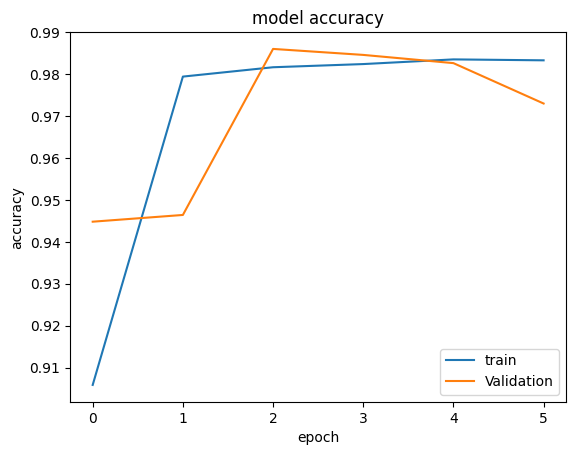

In [19]:
plt.plot(btpdmodel.history['accuracy'])
plt.plot(btpdmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.show()

In [20]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.04355
Test Accuracy: 98.78%
375/375 [==============================] - 11s 29ms/step


<ipython-input-20-46f50f0e28e6>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


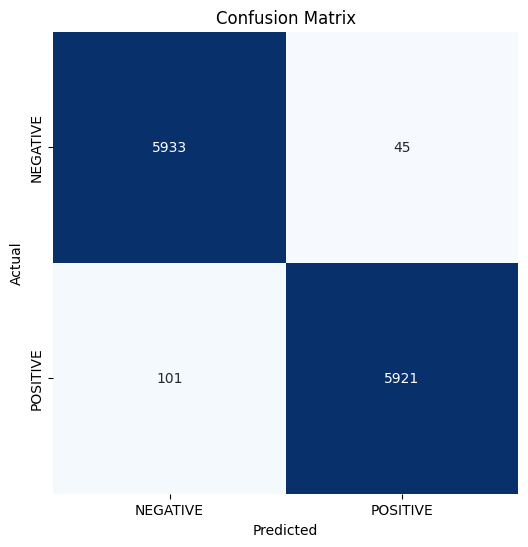

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.99      0.99      5978
    POSITIVE       0.99      0.98      0.99      6022

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [21]:
evaluate_model(model, test_data)

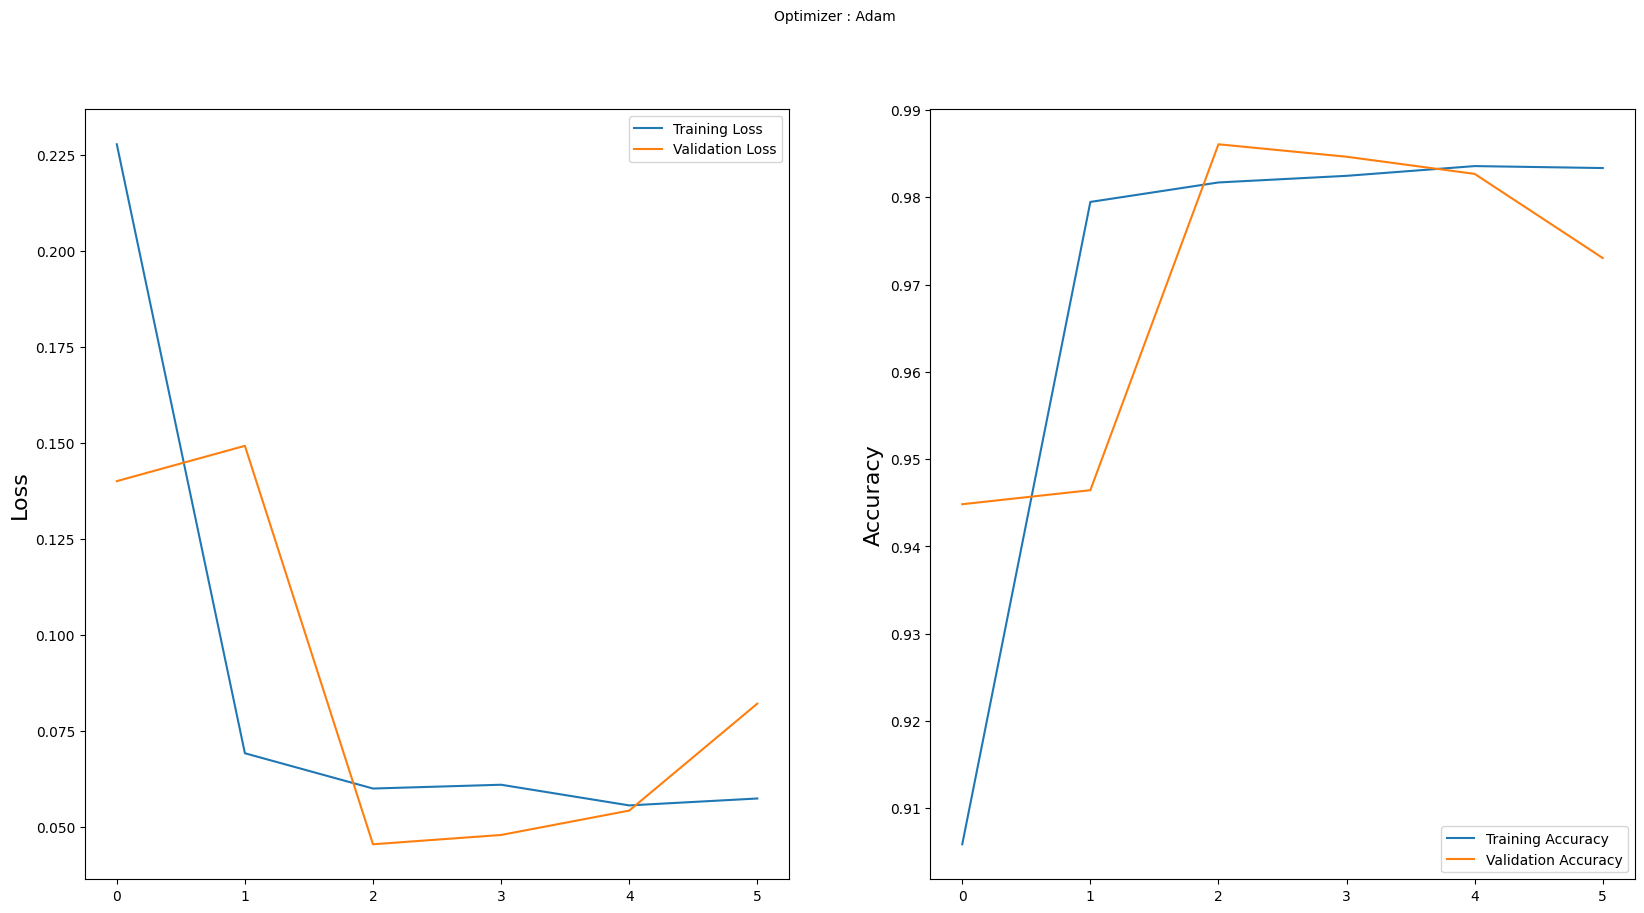

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(btpdmodel.history['loss'], label='Training Loss')
plt.plot(btpdmodel.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(btpdmodel.history['accuracy'], label='Training Accuracy')
plt.plot(btpdmodel.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
from tensorflow import keras

# Assuming you have a model called 'model' already trained or loaded
model.save('/content/powerful_model.h5')

In [24]:
from google.colab import files

files.download('/content/powerful_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import os
import cv2
import PIL
from tensorflow.keras.preprocessing import image

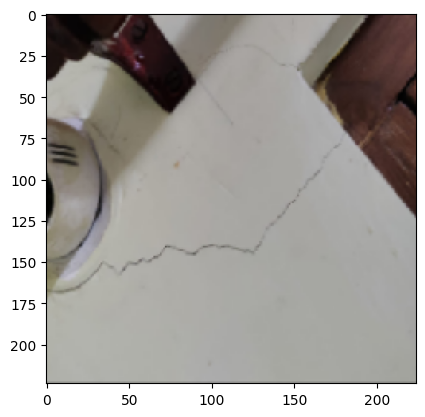

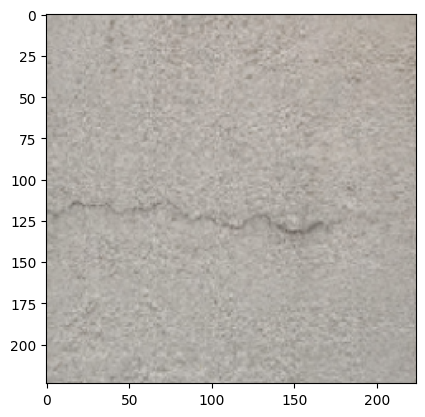

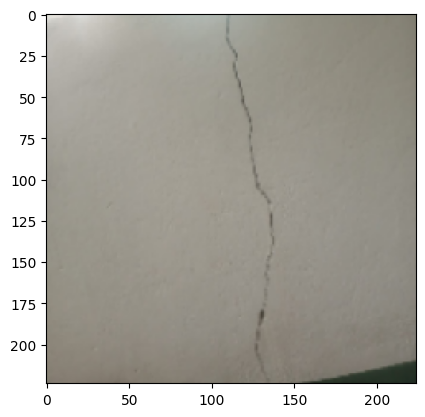

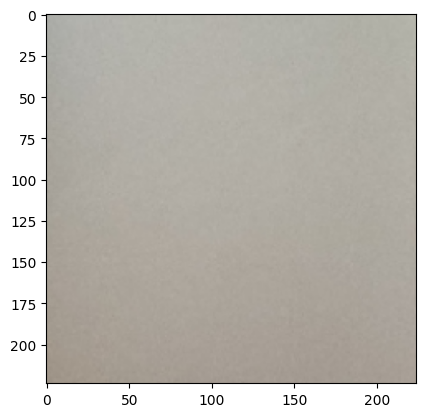

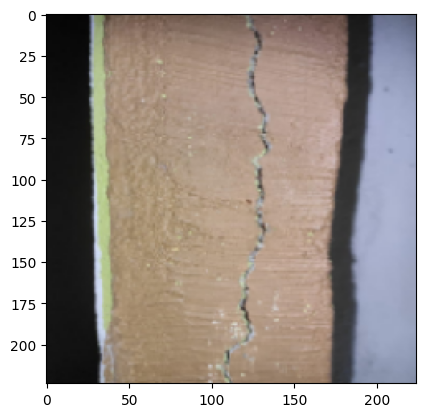

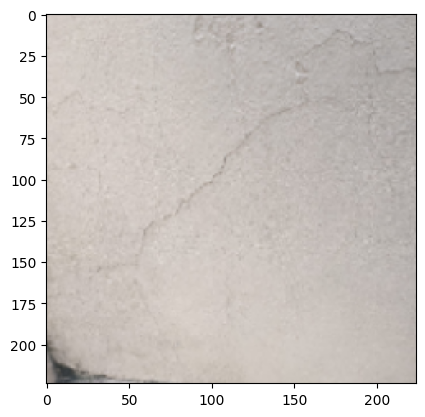

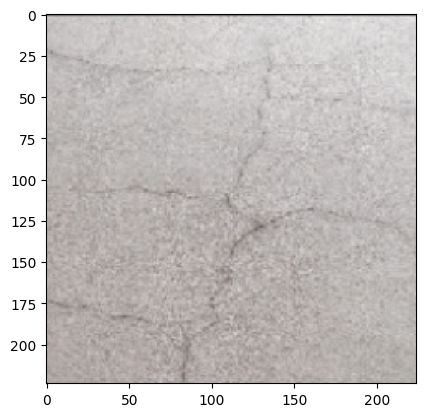

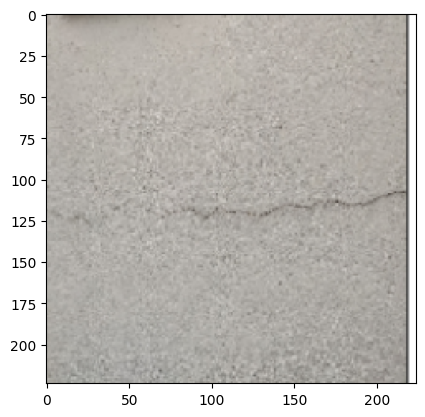

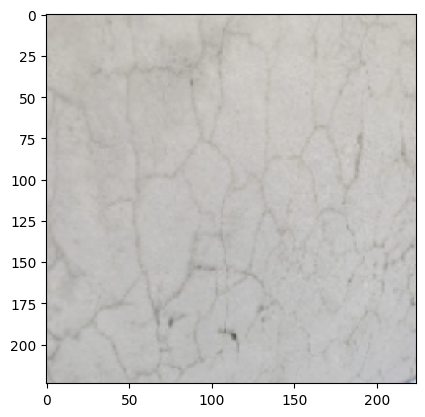

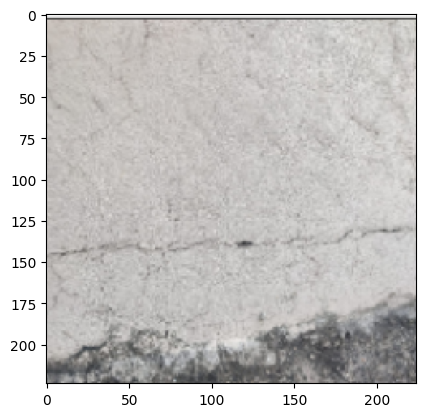

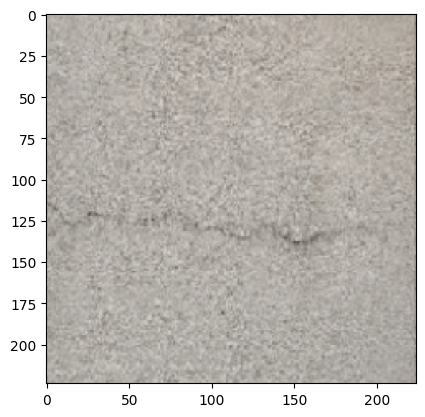

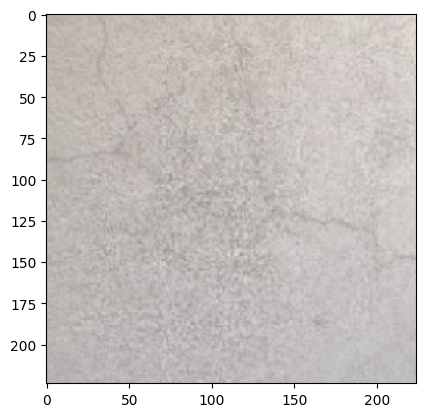

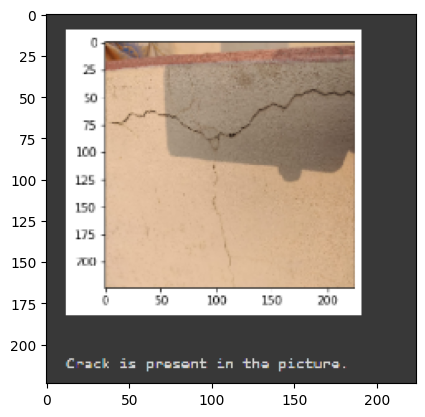

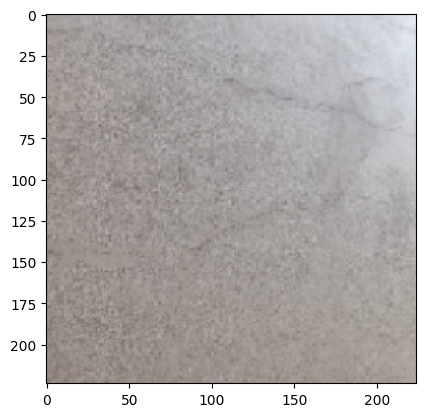

In [52]:
dir_list=os.listdir('/content/drive/MyDrive/examples')
for i in dir_list:
  path1='/content/drive/MyDrive/examples'+'/'+i
  img = image.load_img(path1, target_size=(224, 224))
  plt.imshow(img)
  plt.show()

In [44]:
example_dir=Path('/content/drive/MyDrive/examples')
example_dir

PosixPath('/content/drive/MyDrive/examples')

In [45]:
example_df=creat_dataframe(example_dir,label='EXAMPLE')
print(example_df)

                                             Filepath    Label
0   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
1   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
2   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
3   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
4   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
5   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
6   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
7   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
8   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
9   /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
10  /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
11  /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
12  /content/drive/MyDrive/examples/crackdetection...  EXAMPLE
13  /content/drive/MyDrive/examples/crackdetection...  EXAMPLE


In [46]:
example_data=test_gen.flow_from_dataframe(
dataframe=example_df,
x_col="Filepath",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
)

Found 14 validated image filenames.


In [50]:
from tensorflow.keras.models import load_model

# Replace '/content/drive/My Drive/path/to/your/model.h5' with the actual path to your model file
model_path = '/content/model.h5'

model = load_model(model_path)

1/1 [==============================] - 0s 317ms/step


<ipython-input-54-c3d2c21092c6>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr=(model.predict(example_data)>=0.5).astype(np.int)


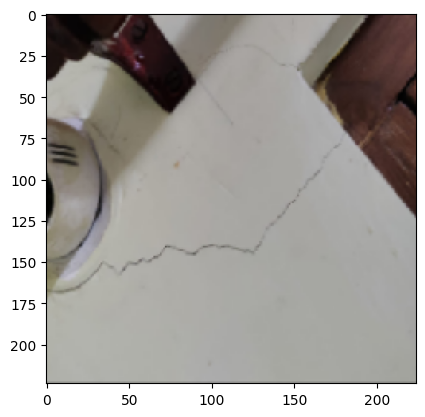

The image has crack


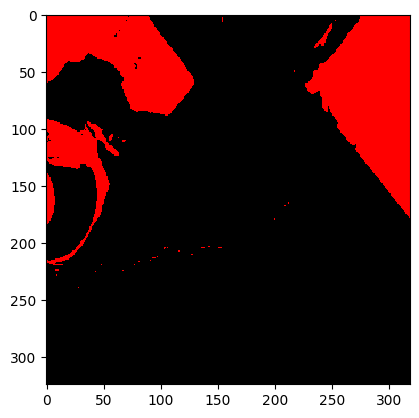

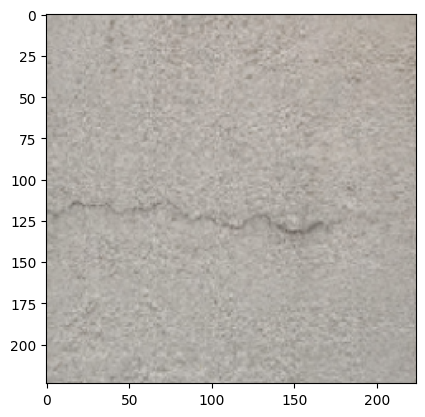

The image does not have the crack


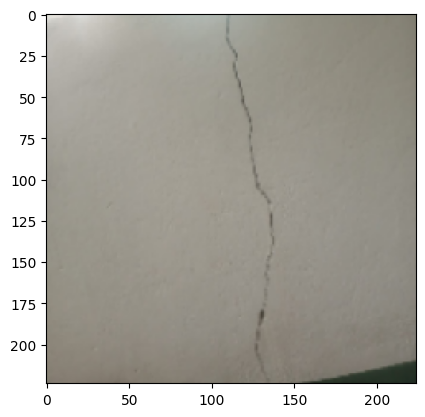

The image does not have the crack


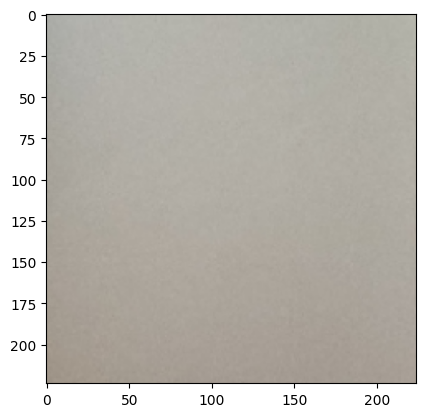

The image does not have the crack


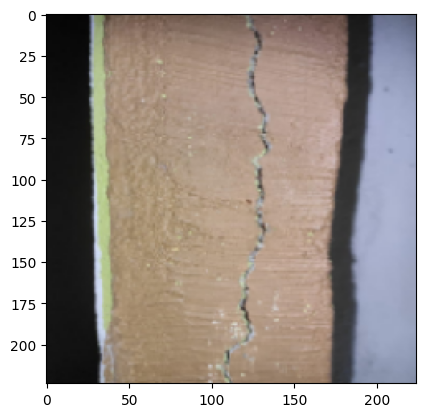

The image has crack


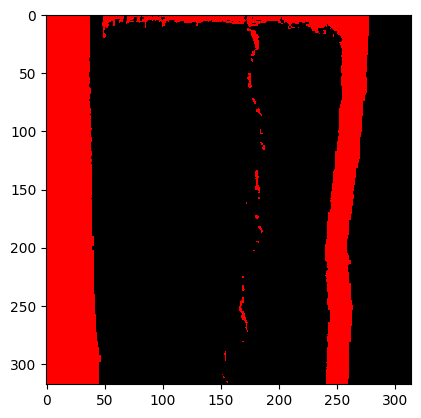

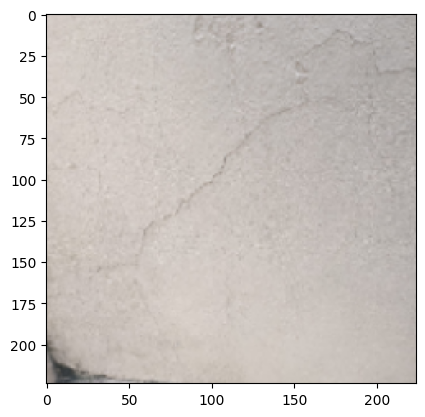

The image does not have the crack


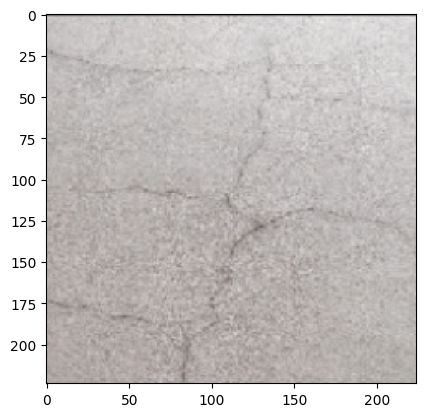

The image does not have the crack


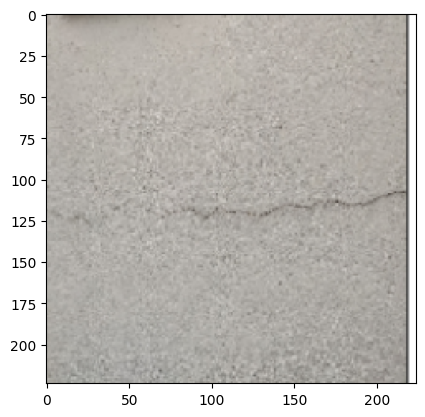

The image does not have the crack


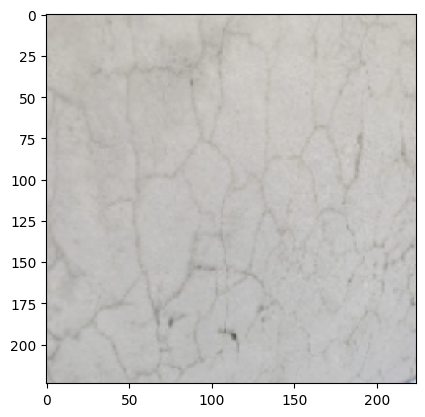

The image does not have the crack


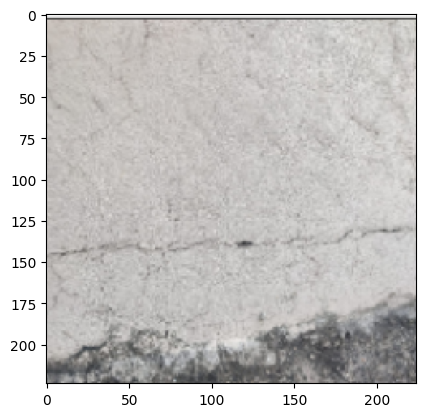

The image has crack


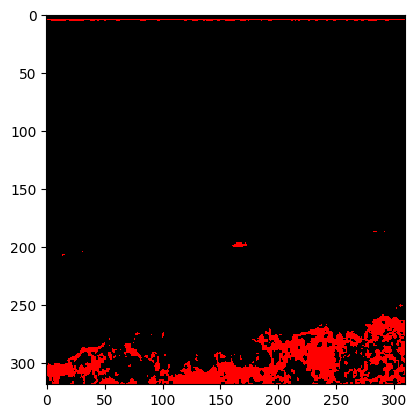

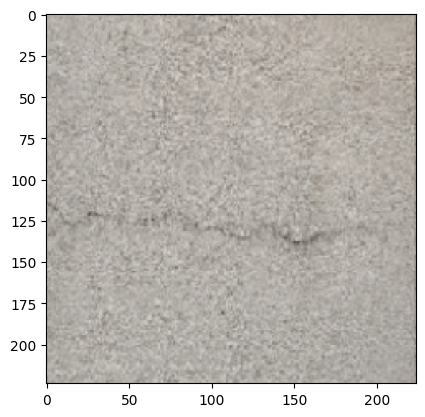

The image does not have the crack


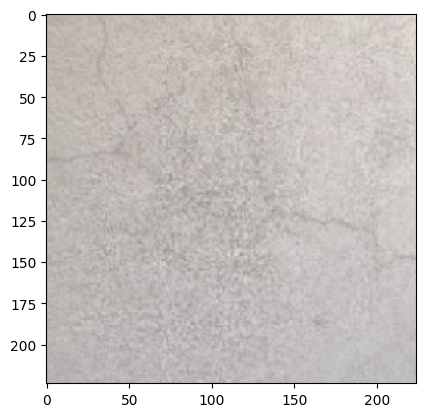

The image does not have the crack


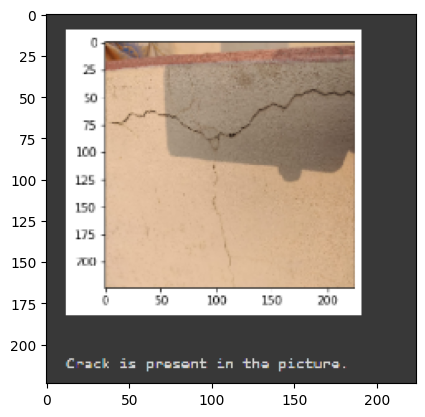

The image has crack


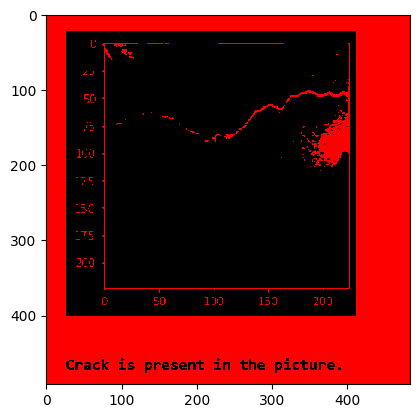

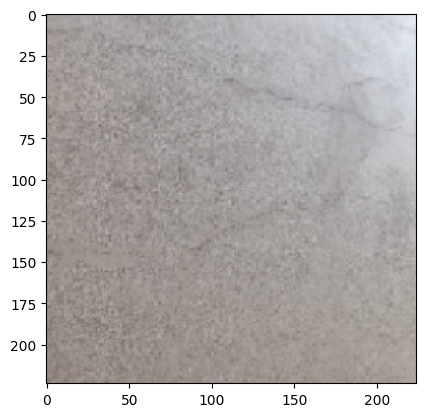

The image does not have the crack


In [54]:
arr=(model.predict(example_data)>=0.5).astype(np.int)
k=0
for i in dir_list:
  path1='/content/drive/MyDrive/examples'+'/'+i
  img = image.load_img(path1, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  if(arr[k]==1):
    print("The image has crack")
    Image = cv2.imread(path1)
    Image2 = np.array(Image, copy=True)
    red_px = np.asarray([255, 0, 0])
    black_px = np.asarray([0  , 0  , 0  ])
    (row, col, _) = Image.shape
    for r in range(0,row):
      for c in range(0,col):
          px = Image[r][c]
          if(px[0]<120 and px[1]<120 and px[2]<120):
            Image2[r][c] = red_px
          else:
           Image2[r][c] = black_px
    plt.imshow(Image2, interpolation='nearest')
    plt.show()
  else:
    print("The image does not have the crack")
  k=k+1

In [ ]:
from google.colab import files


# Specify export directory and use tensorflow to save your_model
export_dir = './saved_model'
tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
files.download(export_dir + '/saved_model.pb')

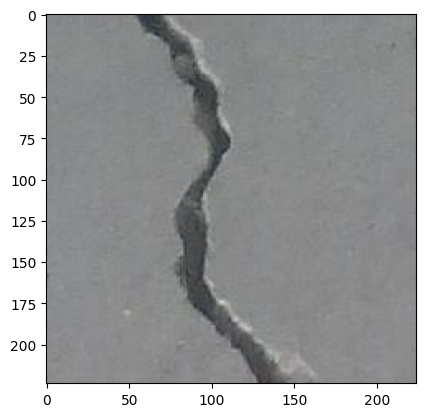

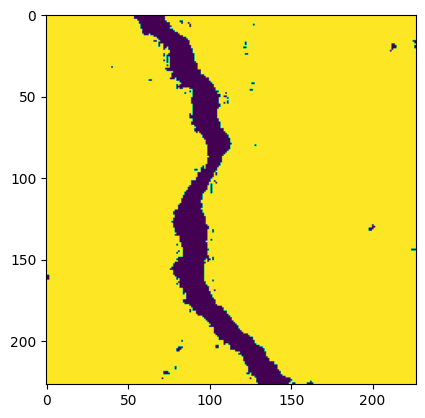

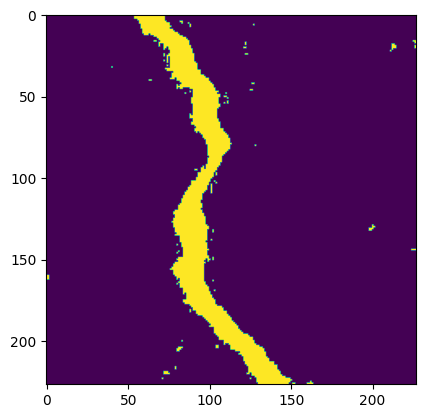

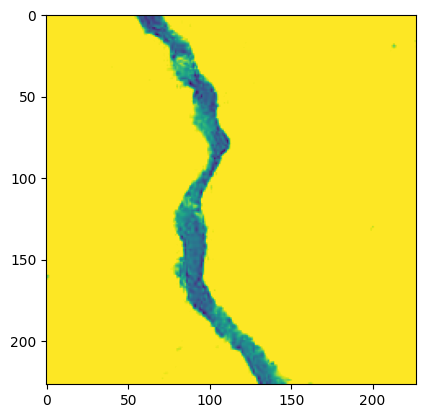

(227, 227)
127


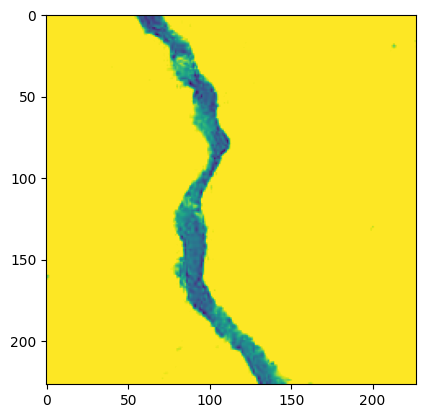

The crack/total area percentage is:  7.637117346938775


In [56]:

# Loading the image named test.jpg
img = cv2.imread(r"/content/dataset/Positive/00003.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img1 = image.load_img("/content/dataset/Positive/00003.jpg", target_size=(224, 224))
plt.imshow(img1)
plt.show()

ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Displaying the output image
plt.imshow(thresh1)
plt.show()
ret, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh2)
plt.show()
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
plt.imshow(thresh3)
plt.show()
c=0
n=0
print(thresh3.shape)
print(thresh3[0][0])
for i in range(0,224):
  for j in range(0,224):
    if(thresh1[i][j]>100):
      n=n+1
    else:
      c=c+1
plt.imshow(thresh3)
plt.show()
cbn = c*100/(c+n)
print('The crack/total area percentage is: ',cbn)

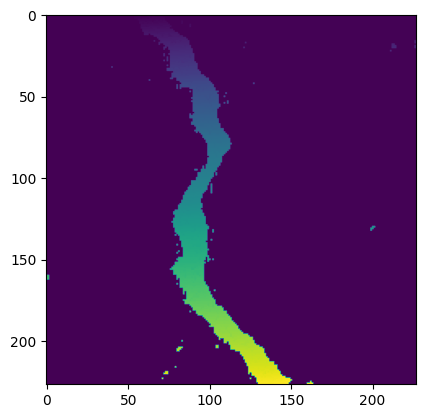

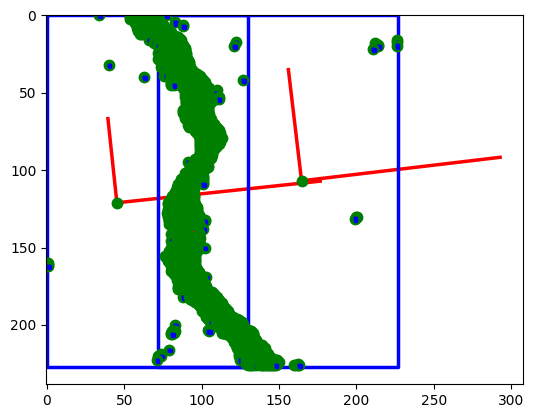

In [57]:
from skimage.measure import label, regionprops_table
import pandas as pd
import math
from skimage.measure import regionprops
# connected pixels of same label get assigned a value
label_img = label(thresh3)
plt.imshow(label_img)
plt.show()
regions=regionprops(label_img)
props = regionprops_table(label_img, properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length'))

df = pd.DataFrame(props)
df
fix, ax = plt.subplots()

ax.imshow(thresh3,cmap=plt.cm.gray)
for props in regions:
    y0, x0 = props.centroid


    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)


    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

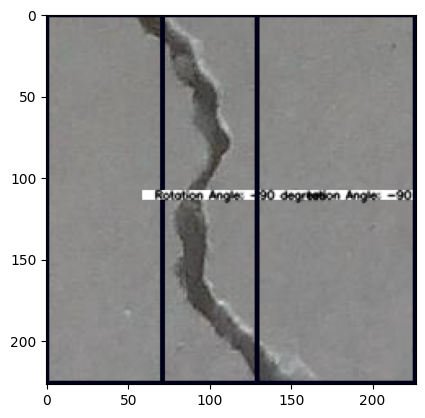

True

In [58]:
img = cv2.imread(r"/content/dataset/Positive/00003.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert image to binary
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Find all the contours in the thresholded image
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):

  # Calculate the area of each contour
  area = cv2.contourArea(c)

  # Ignore contours that are too small or too large
  if area < 3700 or 100000 < area:
    continue

  # cv.minAreaRect returns:
  # (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(c)
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # Retrieve the key parameters of the rotated bounding box
  center = (int(rect[0][0]),int(rect[0][1]))
  width = int(rect[1][0])
  height = int(rect[1][1])
  angle = int(rect[2])


  if width < height:
    angle = 90 - angle
  else:
    angle = -angle

  label = "  Rotation Angle: " + str(angle) + " degrees"
  textbox = cv2.rectangle(img, (center[0]-5, center[1]-5),
    (center[0] + 95, center[1] + 0), (255,255,255), -1)
  cv2.putText(img, label, (center[0]-5, center[1]),
    cv2.FONT_HERSHEY_SIMPLEX, 0.23, (0,0,0), 1, cv2.LINE_AA)
  cv2.drawContours(img,[box],0,(0,0,25),2)

plt.imshow(img)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the output image to the current directory
cv2.imwrite("min_area_rec_output.jpg", img)

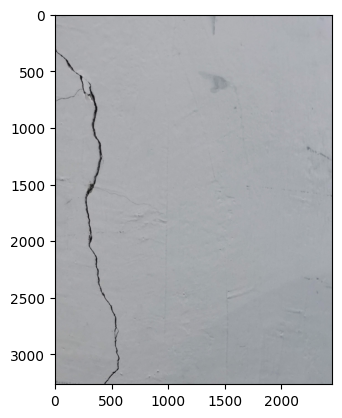

1/1 [==============================] - 0s 21ms/step


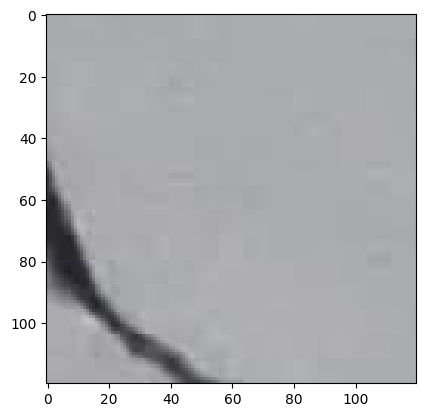

None
1/1 [==============================] - 0s 20ms/step


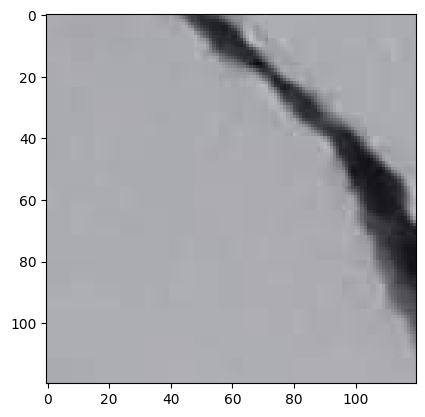

None
1/1 [==============================] - 0s 21ms/step


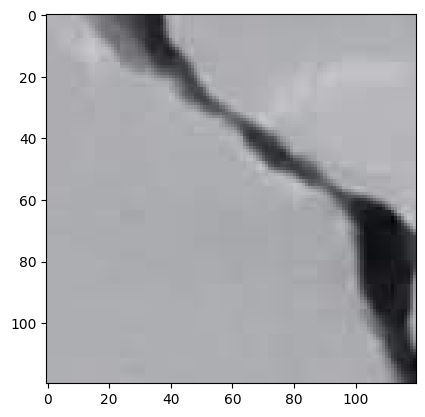

None
1/1 [==============================] - 0s 111ms/step


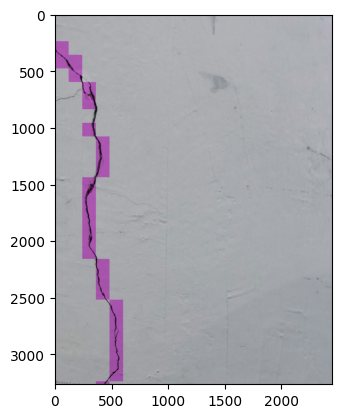

In [63]:
import cv2 as cv
from math import atan2, cos, sin, sqrt, pi
import numpy as np

def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)

  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))

  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
  ## [visualization1]

def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]

  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)

  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]

  ## [visualization]
  # Draw the principal components
  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)

  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]

  # Label with the rotation angle
  label =  str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-5), (cntr[0] + 25, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,0), 1, cv.LINE_AA)

  return angle


def check(img):
  # Was the image there?
  if img is None:
    print("Error: File not found")
    exit(0)
  plt.imshow(img)
  plt.show()

  # Convert image to grayscale
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  # Convert image to binary
  _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

  # Find all the contours in the thresholded image
  contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

  for i, c in enumerate(contours):

    # Calculate the area of each contour
    area = cv.contourArea(c)

    # Ignore contours that are too small or too large
    if area < 3700 or 100000 < area:
      continue

    # Draw each contour only for visualisation purposes
    cv.drawContours(img, contours, i, (0, 0, 255), 2)

    # Find the orientation of each shape
    getOrientation(c, img)

  plt.imshow(img)
  plt.show

# Load the image
img1 = cv.imread(r"/content/drive/MyDrive/IMG_20230430_210438.jpg")
img2 = cv.imread(r"/content/drive/MyDrive/IMG_20230430_210438.jpg")


plt.imshow(img1)
plt.show()
m,n,v=img1.shape
h=0
for i in range(0,m,120):
    for j in range(0,n,120):
        a = img1[i:i + 120, j:j + 120]
        b = np.expand_dims(a, axis=0)
        if(model.predict(b)>=0.5):
            k=check(img1[i:i+120,j:j+120])
            print(k)
            h+=1
            break
    if(h==3):
      break
for i in range(0,m,120):
    for j in range(0,n,120):
       a = img1[i:i + 120, j:j + 120]
       b = np.expand_dims(a, axis=0)
       if(model.predict(b)>=0.5):
            img2[i:i+120,j:j+120,1]=img2[i:i+120,j:j+120,1]/2
plt.imshow(img2)
plt.show()

1200 1200
1/1 [==============================] - 0s 23ms/step


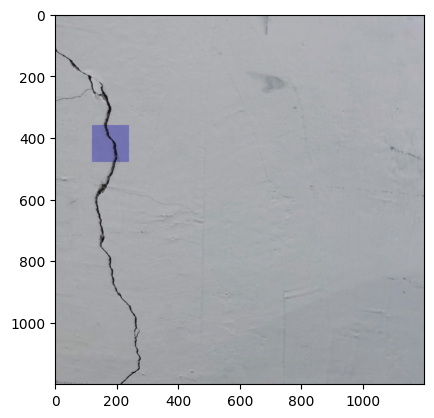

In [65]:
import cv2 as cv
img1 = cv.imread(r"/content/drive/MyDrive/IMG_20230430_210438.jpg")
img1 = cv.resize(img1,(1200,1200))
m,n,v=img1.shape
print(m,n)
h=0

for j in range(0,m,120):
    for k in range(0,n,120):
      a=img1[j:j+120,k:k+120]
      a = np.expand_dims(a, axis=0)
      if(h<3 and model.predict(a)>=0.5):
          h=h+1
          if(h==3):
            img1[j:j + 120, k:k + 120, 0] =img1[j:j + 120, k:k + 120, 0] /1.5
            img1[j:j + 120, k:k + 120, 1] =img1[j:j + 120, k:k + 120, 1] /1.5
plt.imshow(img1)
plt.show()

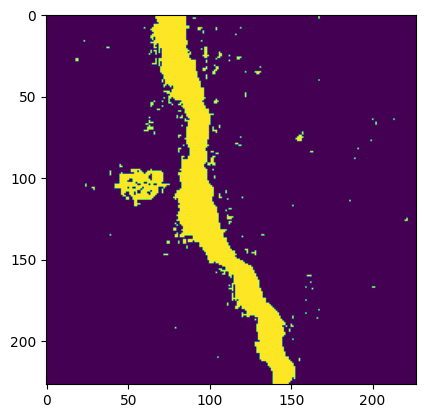

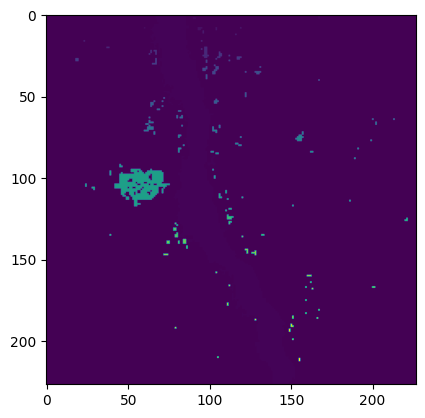

In [66]:
from skimage.measure import label, regionprops_table
cleared = cv2.imread(r"/content/dataset/Positive/00001.jpg")
cleared = cv2.cvtColor(cleared, cv2.COLOR_BGR2GRAY)
ret, cleared = cv2.threshold(cleared, 127, 255, cv2.THRESH_BINARY)
for i in range(0,227):
  for j in range(0,227):
    if(cleared[i][j]==255):
      cleared[i][j]=0
    else:
      cleared[i][j]=255
plt.imshow(cleared)
plt.show()
label_image = label(cleared)
plt.imshow(label_image)
plt.show()

In [67]:

from skimage.measure import label, regionprops_table
img = cv2.imread(r"/content/dataset/Positive/00001.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
label_img=label(img)


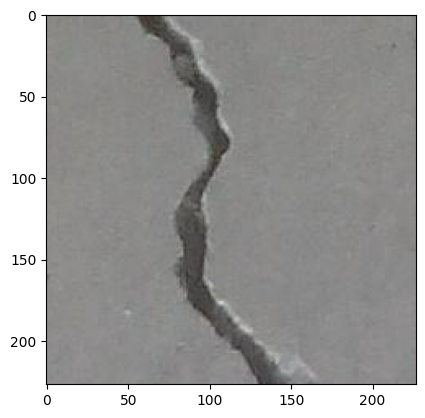

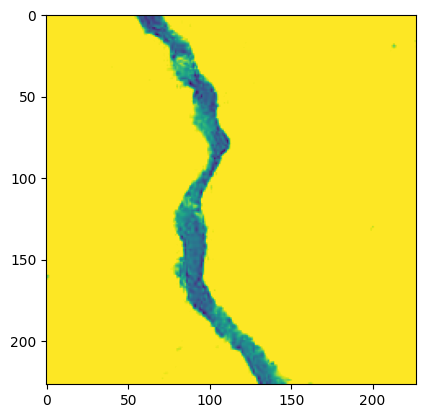

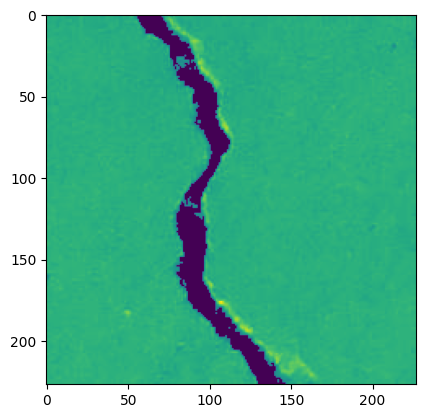

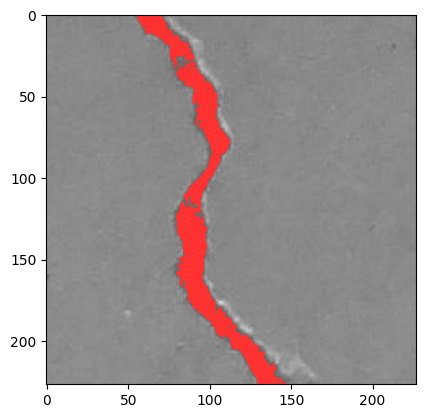

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

import numpy as np

#image loading
image = cv2.imread(r"/content/dataset/Positive/00003.jpg")
#plot image
plt.imshow(image)
plt.show()
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
#plot threshold image
plt.imshow(thresh3)
plt.show()
for i in range(0,227):
  for j in range(0,227):
    if(thresh3[i][j]>=100):
      thresh3[i][j]=img1[i][j] #convert threshold pixel to original image pixel
    else:
      thresh3[i][j]=0
thresh3[0][0]=0       #referece point
plt.imshow(thresh3)
plt.show()
image_rgb = cv2.cvtColor(thresh3, cv2.COLOR_GRAY2RGB)
red_px = np.asarray([255,50,50])
black_px = np.asarray([0  , 0  , 0  ])
(row, col, _) = image_rgb.shape
pxstd1=image_rgb[0][0][0]
pxstd2=image_rgb[0][0][1]
pxstd3=image_rgb[0][0][2]
for r in range(0,row):
  for c in range(0,col):
    if(image_rgb[r][c][0]==pxstd1 or image_rgb[r][c][1]==pxstd2 or image_rgb[r][c][2]==pxstd3):
      image_rgb[r][c] = red_px     #converted cracked pixel to red colour pixel
plt.imshow(image_rgb)
plt.show()

